In [2]:
%reset -f
import sys
sys.path.append('/home/psimmerl/mds_analysis')

import pathlib

import math
import numpy as np
import numba as nb
from math import ceil, floor

from src.histo_utilities import std_color_list as SCL
# from src.helper_functions import alert, Table, weight_calc

from src import CMS_lumi, tdrstyle
root_style = tdrstyle.setTDRStyle()

import ROOT as rt
from ROOT import RDataFrame
from ROOT import TCanvas, TLatex, TLegend, TLine, TBox
from ROOT import TH1D, TH2D, TGraph, TGraphErrors, TGraphAsymmErrors


# **************************** #
LOCAL_DIR = '/home/psimmerl/mds_analysis'
OUT_DIR = f'{LOCAL_DIR}/reports/weekly/2024-04-15'

# **** #
MET_CATEGORY = ('lt200', 'low', 'high')[1]
TAG_CATEGORY = ('csccsc', 'cscdt')[1]
CUTSET = ('l1', 'scs', 'ropt', 'roptDNN', 'lopt', 'loptDNN')[3]
OOT = True#False#

SIZE_VAR = TAG_CATEGORY[3:]

FN_MC = f'{LOCAL_DIR}/data/processed/mc_{TAG_CATEGORY}_{CUTSET}_{MET_CATEGORY}_rdf.root'
# FN_MC = f'{LOCAL_DIR}/data/processed/mc_{TAG_CATEGORY}{"OOT" if OOT else ""}_{CUTSET}_{MET_CATEGORY}_rdf.root'
FN_R3 = f'{LOCAL_DIR}/data/processed/r3_{TAG_CATEGORY}{"OOT" if OOT else ""}_{CUTSET}_{MET_CATEGORY}_rdf.root'

# **** #
# STANDARD CUT SELECTION
if CUTSET == 'scs':
    if TAG_CATEGORY == 'csccsc':
        if MET_CATEGORY == 'lt200':
            ABCD_DPHI = None
            ABCD_SIZE = None
        if MET_CATEGORY == 'low':
            ABCD_DPHI = None
            ABCD_SIZE = None
        if MET_CATEGORY == 'high':
            ABCD_DPHI = None
            ABCD_SIZE = None

    if TAG_CATEGORY == 'cscdt':
        if MET_CATEGORY == 'lt200':
            ABCD_DPHI = None
            ABCD_SIZE = None
        if MET_CATEGORY == 'low':
            ABCD_DPHI = 2.65
            ABCD_SIZE = 134
        if MET_CATEGORY == 'high':
            ABCD_DPHI = 1.40
            ABCD_SIZE = 128

if CUTSET == 'roptDNN':
    if TAG_CATEGORY == 'csccsc':
        if MET_CATEGORY == 'lt200':
            ABCD_DPHI = None
            ABCD_SIZE = None
        if MET_CATEGORY == 'low':
            ABCD_DPHI = None
            ABCD_SIZE = None
        if MET_CATEGORY == 'high':
            ABCD_DPHI = None
            ABCD_SIZE = None

    if TAG_CATEGORY == 'cscdt':
        if MET_CATEGORY == 'lt200':
            ABCD_DPHI = None
            ABCD_SIZE = None
        if MET_CATEGORY == 'low':
            ABCD_DPHI = 2.75
            ABCD_SIZE = 84
        if MET_CATEGORY == 'high':
            ABCD_DPHI = 2.55
            ABCD_SIZE = 113

if CUTSET == 'lopt':
    if TAG_CATEGORY == 'csccsc':
        if MET_CATEGORY == 'lt200':
            ABCD_DPHI = None
            ABCD_SIZE = None
        if MET_CATEGORY == 'low':
            ABCD_DPHI = None
            ABCD_SIZE = None
        if MET_CATEGORY == 'high':
            ABCD_DPHI = None
            ABCD_SIZE = None

    if TAG_CATEGORY == 'cscdt':
        if MET_CATEGORY == 'lt200':
            ABCD_DPHI = None
            ABCD_SIZE = None
        if MET_CATEGORY == 'low':
            ABCD_DPHI = 2.65
            ABCD_SIZE = 94
        if MET_CATEGORY == 'high':
            ABCD_DPHI = 1.65
            ABCD_SIZE = 113

if CUTSET == 'loptDNN':
    if TAG_CATEGORY == 'csccsc':
        if MET_CATEGORY == 'lt200':
            ABCD_DPHI = None
            ABCD_SIZE = None
        if MET_CATEGORY == 'low':
            ABCD_DPHI = None
            ABCD_SIZE = None
        if MET_CATEGORY == 'high':
            ABCD_DPHI = None
            ABCD_SIZE = None

    if TAG_CATEGORY == 'cscdt':
        if MET_CATEGORY == 'lt200':
            ABCD_DPHI = None
            ABCD_SIZE = None
        if MET_CATEGORY == 'low':
            ABCD_DPHI = 2.75
            ABCD_SIZE = 84
        if MET_CATEGORY == 'high':
            ABCD_DPHI = 2.55
            ABCD_SIZE = 113

# **** #
pathlib.Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

# rt.gErrorIgnoreLevel = 1001  # rt.kInfo + 1
# rt.gROOT.SetBatch(True)
PI = rt.TMath.Pi()

# rt.EnableImplicitMT(4)
# print('Enabled ROOT\'s implicit multithreading (sometimes causes a crash)')

gc = []

# **************** #
print(f'{MET_CATEGORY=}')
print(f'{TAG_CATEGORY=}')
print(f'{CUTSET=}')
print(f'{OOT=}')
print('')

print(f'{ABCD_DPHI=}')
print(f'{ABCD_SIZE=}')
print('')

print(f'{FN_MC=}')
print(f'{FN_R3=}')
print(f'{OUT_DIR=}')
print('')

# **************** #
rdfs = {
    'mc' : RDataFrame('MuonSystem_flat', FN_MC),
    'r3' : RDataFrame('MuonSystem_flat', FN_R3),
}

print('Events Read:')
for key, rdf in rdfs.items():
    if TAG_CATEGORY == 'csccsc':
        # rdf = rdf.Filter('tag_dR > 1.5')
        rdf = rdf.Alias('tag_size', 'csc1Size')
        rdf = rdf.Alias('tag_ctau', 'csc1CTau')

    if TAG_CATEGORY == 'cscdt':
        # rdf = rdf.Filter('tag_dPhi > 0.4')
        rdf = rdf.Alias('tag_size', 'dtSize')
        rdf = rdf.Alias('tag_ctau', 'dtCTau')

    count, weight = rdf.Count().GetValue(), rdf.Sum('weight').GetValue()
    print(f'  {key} = {count:,} ({weight:,.2f})')

    rdfs[key] = rdf


Welcome to JupyROOT 6.30/04
MET_CATEGORY='low'
TAG_CATEGORY='cscdt'
CUTSET='roptDNN'
OOT=True

ABCD_DPHI=2.75
ABCD_SIZE=84

FN_MC='/home/psimmerl/mds_analysis/data/processed/mc_cscdt_roptDNN_low_rdf.root'
FN_R3='/home/psimmerl/mds_analysis/data/processed/r3_cscdtOOT_roptDNN_low_rdf.root'
OUT_DIR='/home/psimmerl/mds_analysis/reports/weekly/2024-04-15'

Events Read:
  mc = 2,331 (1,408.13)
  r3 = 209 (209.00)


In [3]:
if 'OOT' not in FN_R3:
    raise Warning('data is not OOT!')

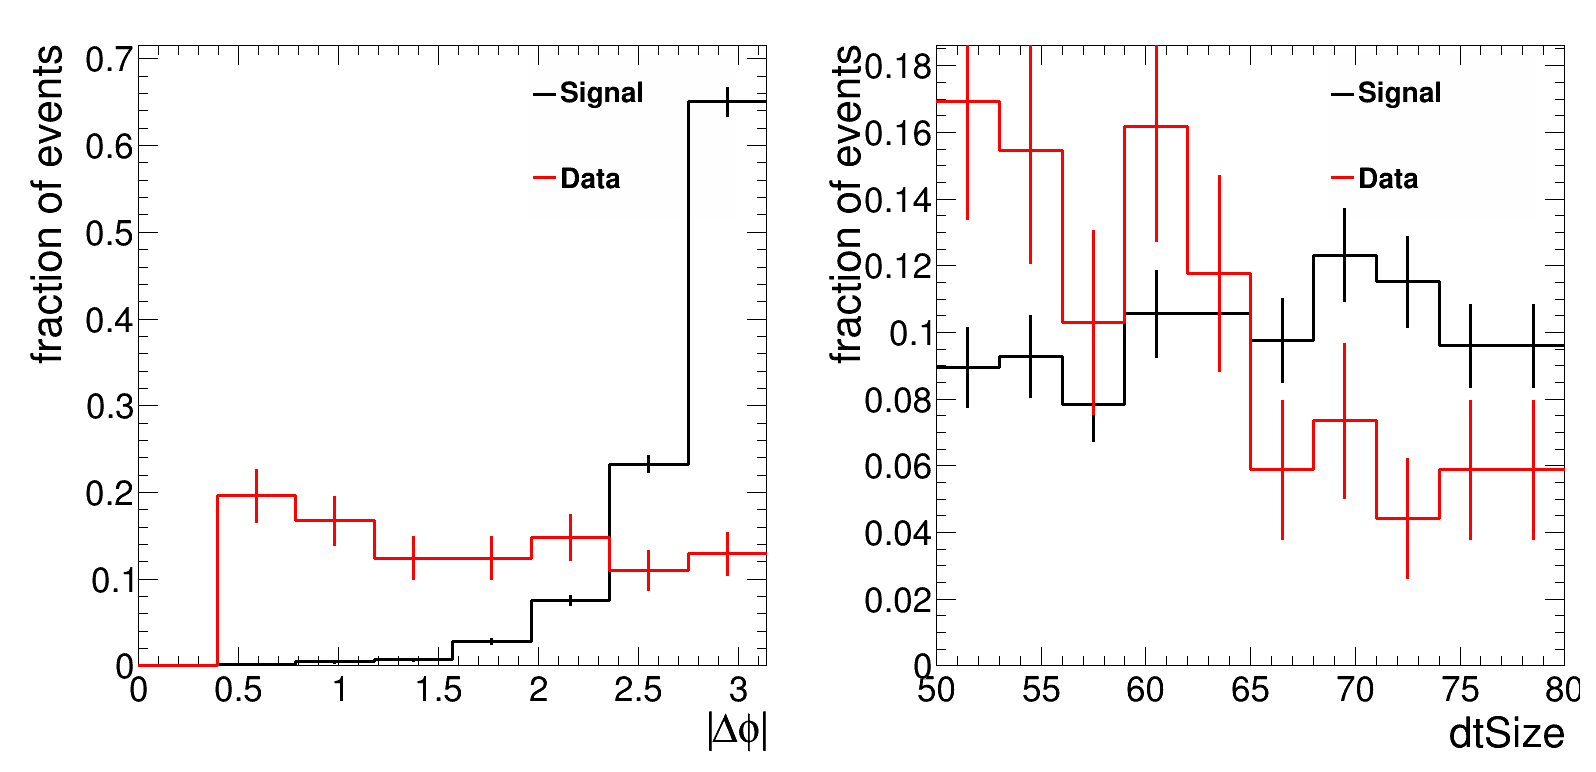

In [4]:
canvas = TCanvas('','',2*800,800)
canvas.Divide(2,1)
canvas.SetGrid()

hinfos = { 
    'tag_dPhi' : {
        'form' : (f';|#Delta#phi|;fraction of events',32,0,np.pi),
        'form' : (f';|#Delta#phi|;fraction of events',16,0,np.pi),
        'form' : (f';|#Delta#phi|;fraction of events',8,0,np.pi),
    },
   'dtSize' : {
        # 'form' : (f';dtSize;fraction of events',25,65,100),
        # 'form' : (f';dtSize;fraction of events',15,50,80),
        'form' : (f';dtSize;fraction of events',10,50,80),
        # 'form' : (f';dtSize;fraction of events',25,50,500),
    },
    # 'csc0Phi' : {
    #     'form' : (f';#phi_{{var}};fraction of events',32,0,np.pi),
    # },
}

for ixv, (xv, hinfo) in enumerate(hinfos.items()):
    canvas.cd(ixv+1)
    # canvas.cd(ixv+1).SetLogy()
    form = hinfo['form']

    # **** #
    legend = TLegend(0.67, 0.72, 0.94, 0.94)
    legend.SetBorderSize(0)
    legend.SetFillColorAlpha(rt.kBlack, 0.0)#0.2)
    legend.SetTextSize(0.04)
    legend.SetMargin(0.15)


    # **** #

    h1 = rdfs['mc'].Histo1D(('Signal',*form),xv,).GetValue()
    h2 = rdfs['r3'].Histo1D(('Data',*form),xv,).GetValue()

    hhs = [h1,h2]
    # hmax = max([h.GetMaximum() for h in hhs])
    hmax = max([h.GetMaximum() / h.Integral() if h.Integral() else 0 for h in hhs])
    for ih, hh in enumerate(hhs):
        nev = hh.Integral()
        if hmax < 1 and nev:
            hh.Scale(1/hh.Integral())
        hh.SetMinimum(0)
        hh.SetMaximum(hmax*1.1)
        hh.SetLineColor(SCL[ih])
        hh.SetLineWidth(3)
        hh.Draw('histe same')
        legend.AddEntry(hh, hh.GetName(), 'L')


    legend.Draw()
    gc.extend([legend]+hhs)
canvas.Draw()


# ABCD Optimization


In [5]:
# sizes = np.linspace(50,150,101) #if ABCD_SIZE is None else np.array([ABCD_SIZE])
# dphis = np.linspace(0.4,np.pi,50) #if ABCD_DPHI is None else np.array([ABCD_DPHI])
''' CSC-DT
s2b   = 944.8692401312594
dphi  = 2.302329596368428
size  = 72.0
a_mc  = 668.1234470313939
ap_r3 = 0.5
'''

min_dphi = max([rdf.Min('tag_dPhi').GetValue() for k, rdf in rdfs.items()])
max_dphi = min([rdf.Max('tag_dPhi').GetValue() for k, rdf in rdfs.items()])
min_size = max([rdf.Min('tag_size').GetValue() for k, rdf in rdfs.items()])
max_size = min([rdf.Max('tag_size').GetValue() for k, rdf in rdfs.items()])
# if TAG_CATEGORY == 'csc' and MET_CATEGORY == 'low':
#     min_dphi = 1
# elif TAG_CATEGORY == 'csc' and MET_CATEGORY == 'high':
#     min_dphi = 0
# elif TAG_CATEGORY == 'dt' and MET_CATEGORY == 'low':
#     min_dphi = 0.4
# elif TAG_CATEGORY == 'dt' and MET_CATEGORY == 'high':
#     min_dphi = 0.4


# sizes = np.linspace(50,150,101)
# dphis = np.linspace(2/3*np.pi,np.pi,50)
# dphis = np.linspace(min_dphi,np.pi,50)

# sizes = np.arange(100,150+1,1)
sizes = np.arange(max(50,min_size),min(150,max_size)+1,1)
dphis = np.arange(max(1.00,(min_dphi//0.5)*0.5),min(3.15,(max_dphi//0.05)*0.05)+0.05,0.05)
# dphis = np.arange(min_dphi,3.15+0.05,0.05)
''' CSC-DT
s2b   = 955.1209859554683
dphi  = 2.2653661311599866
size  = 72.0
a_mc  = 675.3725260226929
ap_r3 = 0.5
'''

if 'high' in FN_MC:
    a_mc_scan = [ [rdfs['mc'].Filter(f'(tag_dPhi < {dp}) && (tag_size >= {sz})').Sum('weight') for sz in sizes] for dp in dphis ]
    b_mc_scan = [ [rdfs['mc'].Filter(f'(tag_dPhi < {dp}) && (tag_size < {sz})').Sum('weight') for sz in sizes] for dp in dphis ]
    c_mc_scan = [ [rdfs['mc'].Filter(f'(tag_dPhi >= {dp}) && (tag_size < {sz})').Sum('weight') for sz in sizes] for dp in dphis ]
    d_mc_scan = [ [rdfs['mc'].Filter(f'(tag_dPhi >= {dp}) && (tag_size >= {sz})').Sum('weight') for sz in sizes] for dp in dphis ]

    a_r3_scan = [ [rdfs['r3'].Filter(f'(tag_dPhi < {dp}) && (tag_size >= {sz})').Sum('weight') for sz in sizes] for dp in dphis ]
    b_r3_scan = [ [rdfs['r3'].Filter(f'(tag_dPhi < {dp}) && (tag_size < {sz})').Sum('weight') for sz in sizes] for dp in dphis ]
    c_r3_scan = [ [rdfs['r3'].Filter(f'(tag_dPhi >= {dp}) && (tag_size < {sz})').Sum('weight') for sz in sizes] for dp in dphis ]
    d_r3_scan = [ [rdfs['r3'].Filter(f'(tag_dPhi >= {dp}) && (tag_size >= {sz})').Sum('weight') for sz in sizes] for dp in dphis ]
else:
    a_mc_scan = [ [rdfs['mc'].Filter(f'(tag_dPhi >= {dp}) && (tag_size >= {sz})').Sum('weight') for sz in sizes] for dp in dphis ]
    b_mc_scan = [ [rdfs['mc'].Filter(f'(tag_dPhi >= {dp}) && (tag_size < {sz})').Sum('weight') for sz in sizes] for dp in dphis ]
    c_mc_scan = [ [rdfs['mc'].Filter(f'(tag_dPhi < {dp}) && (tag_size < {sz})').Sum('weight') for sz in sizes] for dp in dphis ]
    d_mc_scan = [ [rdfs['mc'].Filter(f'(tag_dPhi < {dp}) && (tag_size >= {sz})').Sum('weight') for sz in sizes] for dp in dphis ]

    a_r3_scan = [ [rdfs['r3'].Filter(f'(tag_dPhi >= {dp}) && (tag_size >= {sz})').Sum('weight') for sz in sizes] for dp in dphis ]
    b_r3_scan = [ [rdfs['r3'].Filter(f'(tag_dPhi >= {dp}) && (tag_size < {sz})').Sum('weight') for sz in sizes] for dp in dphis ]
    c_r3_scan = [ [rdfs['r3'].Filter(f'(tag_dPhi < {dp}) && (tag_size < {sz})').Sum('weight') for sz in sizes] for dp in dphis ]
    d_r3_scan = [ [rdfs['r3'].Filter(f'(tag_dPhi < {dp}) && (tag_size >= {sz})').Sum('weight') for sz in sizes] for dp in dphis ]

a_mc_scan = np.array([ [xx.GetValue() for xx in x] for x in a_mc_scan ])
b_mc_scan = np.array([ [xx.GetValue() for xx in x] for x in b_mc_scan ])
c_mc_scan = np.array([ [xx.GetValue() for xx in x] for x in c_mc_scan ])
d_mc_scan = np.array([ [xx.GetValue() for xx in x] for x in d_mc_scan ])

a_r3_scan = np.array([ [xx.GetValue() for xx in x] for x in a_r3_scan ])
b_r3_scan = np.array([ [xx.GetValue() for xx in x] for x in b_r3_scan ])
c_r3_scan = np.array([ [xx.GetValue() for xx in x] for x in c_r3_scan ])
d_r3_scan = np.array([ [xx.GetValue() for xx in x] for x in d_r3_scan ])

ap_mc_scan = np.divide(b_mc_scan*d_mc_scan, c_mc_scan, where=c_mc_scan>0, out=np.zeros_like(a_mc_scan))
ap_r3_scan = np.divide(b_r3_scan*d_r3_scan, c_r3_scan, where=c_r3_scan>0, out=np.zeros_like(a_r3_scan))

In [80]:

# There has to be signal and data in each of the 4 bins for the ABCD method to work
cond = ((a_mc_scan>0) & (b_mc_scan>0) & (c_mc_scan>0) & (d_mc_scan>0)) & \
        ((ap_r3_scan>0) & (b_r3_scan>0) & (c_r3_scan>0) & (d_r3_scan>0))

# Here we add a condition that the predicted value must be within 2 sigma of the actual value
ae_r3_scan = np.sqrt(a_r3_scan)
ape_r3_scan = ap_r3_scan * np.sqrt(
    np.divide(1,b_r3_scan, where=cond, out=np.zeros_like(b_r3_scan)) +#ones_like(b_r3_scan)) +
    np.divide(1,c_r3_scan, where=cond, out=np.zeros_like(c_r3_scan)) +#ones_like(c_r3_scan)) +
    np.divide(1,d_r3_scan, where=cond, out=np.zeros_like(d_r3_scan))#ones_like(d_r3_scan))
)

cond = cond & (np.divide(np.abs(a_r3_scan-ap_r3_scan),np.sqrt(ae_r3_scan**2 + ape_r3_scan**2), where=cond, out=999*np.ones_like(a_r3_scan))<1)
# cond = cond & (np.divide(np.abs(a_r3_scan-ap_r3_scan),np.sqrt(ape_r3_scan**2), where=cond, out=999*np.ones_like(a_r3_scan))<1)
# cond = cond & (a_mc>700)

cond[1:-1;:] = cond[:-1,:] * cond[1:,:] * cond[1:,-1:] * cond[1:,1:]
(-1,-1)*(-1,0)*(1,0)*(0-1)*(0,0)
####

s2bs = np.divide(a_mc_scan, np.sqrt(ap_r3_scan), where=cond, out=np.zeros_like(a_mc_scan))

# s2bs = np.divide(a_mc_scan, ap_r3_scan, where=cond, out=np.zeros_like(a_mc_scan))
# https://arxiv.org/pdf/hep-ph/0204326.pdf
cond = cond #& (ap_r3_scan<1)
# s2bs = 2*(np.sqrt(a_mc_scan+ap_r3_scan)-np.sqrt(ap_r3_scan))*cond
# s2bs = 2*(np.sqrt(a_mc_scan+ap_r3_scan)-np.sqrt(ap_r3_scan))*cond
s2bs = 2*(np.sqrt(a_mc_scan+ap_r3_scan)-np.sqrt(ap_r3_scan))*cond
# s2bs = 2*(np.sqrt(ap_mc_scan+ap_r3_scan)-np.sqrt(ap_r3_scan))*cond
s2bs = np.sqrt(
    (2*np.sqrt(a_mc_scan+ap_r3_scan)-np.sqrt(ap_r3_scan))**2+
    (2*np.sqrt(b_mc_scan+b_r3_scan)-np.sqrt(b_r3_scan))**2+
    (2*np.sqrt(c_mc_scan+c_r3_scan)-np.sqrt(c_r3_scan))**2+
    (2*np.sqrt(d_mc_scan+d_r3_scan)-np.sqrt(d_r3_scan))**2)*cond
print(np.max(s2bs), (s2bs==np.max(s2bs)).sum())
# adj to limit from run2
# s2bs = 2*(np.sqrt(2.16e-03*a_mc_scan+ap_r3_scan)-np.sqrt(ap_r3_scan))*cond


s2bs[:3,:] = 0
s2bs[-4:,:] = 0
s2bs[:,:3] = 0
s2bs[:,-4:] = 0

idx_s2b = np.unravel_index(np.argmax(s2bs), s2bs.shape)

print(f's2b   = {s2bs[idx_s2b]:.1f}')
# print(f'dphi  = {dphis[idx_s2b[1]]}')
# print(f'size  = {sizes[idx_s2b[0]]}')
print(f'dphi  = {dphis[idx_s2b[0]]:.2f}')
print(f'size  = {sizes[idx_s2b[1]]}')
print(f'a_mc  = {a_mc_scan[idx_s2b]:.1f}')
if 'OOT' not in FN_R3:
    print(f'a_r3 = --')
else:
    print(f'a_r3 = {a_r3_scan[idx_s2b]:.0f}')
print(f'ap_r3 = {ap_r3_scan[idx_s2b]:.1f} +/- {ape_r3_scan[idx_s2b]:.2f}')

ABCD_DPHI = dphis[idx_s2b[0]]
ABCD_SIZE = sizes[idx_s2b[1]]

70.14292737912689 1
s2b   = 69.8
dphi  = 2.35
size  = 78
a_mc  = 938.8
a_r3 = 22
ap_r3 = 16.1 +/- 4.03


(101, 43)

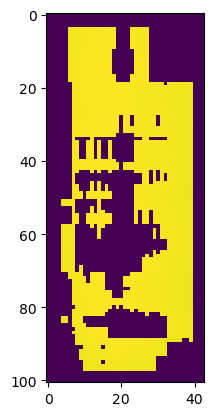

In [81]:
import matplotlib.pyplot as plt
plt.imshow(s2bs.T[:,::-1][::-1,:])
# plt.imshow(ap_mc_scan.T[:,::-1][::-1,:])
len(sizes),len(dphis)

In [82]:
( (a_mc_scan+d_mc_scan)/(a_mc_scan+b_mc_scan+c_mc_scan+d_mc_scan) )[idx_s2b]
( (a_r3_scan+d_r3_scan)/(a_r3_scan+b_r3_scan+c_r3_scan+d_r3_scan) )[idx_s2b]
( (a_r3_scan+b_r3_scan)/(a_r3_scan+b_r3_scan+c_r3_scan+d_r3_scan) )[idx_s2b]

0.23923444976076555

In [83]:
s2bs[idx_s2b], a_mc_scan[idx_s2b] / (ap_r3_scan[idx_s2b]**0.5)

(69.82022353433396, 234.1101671408244)

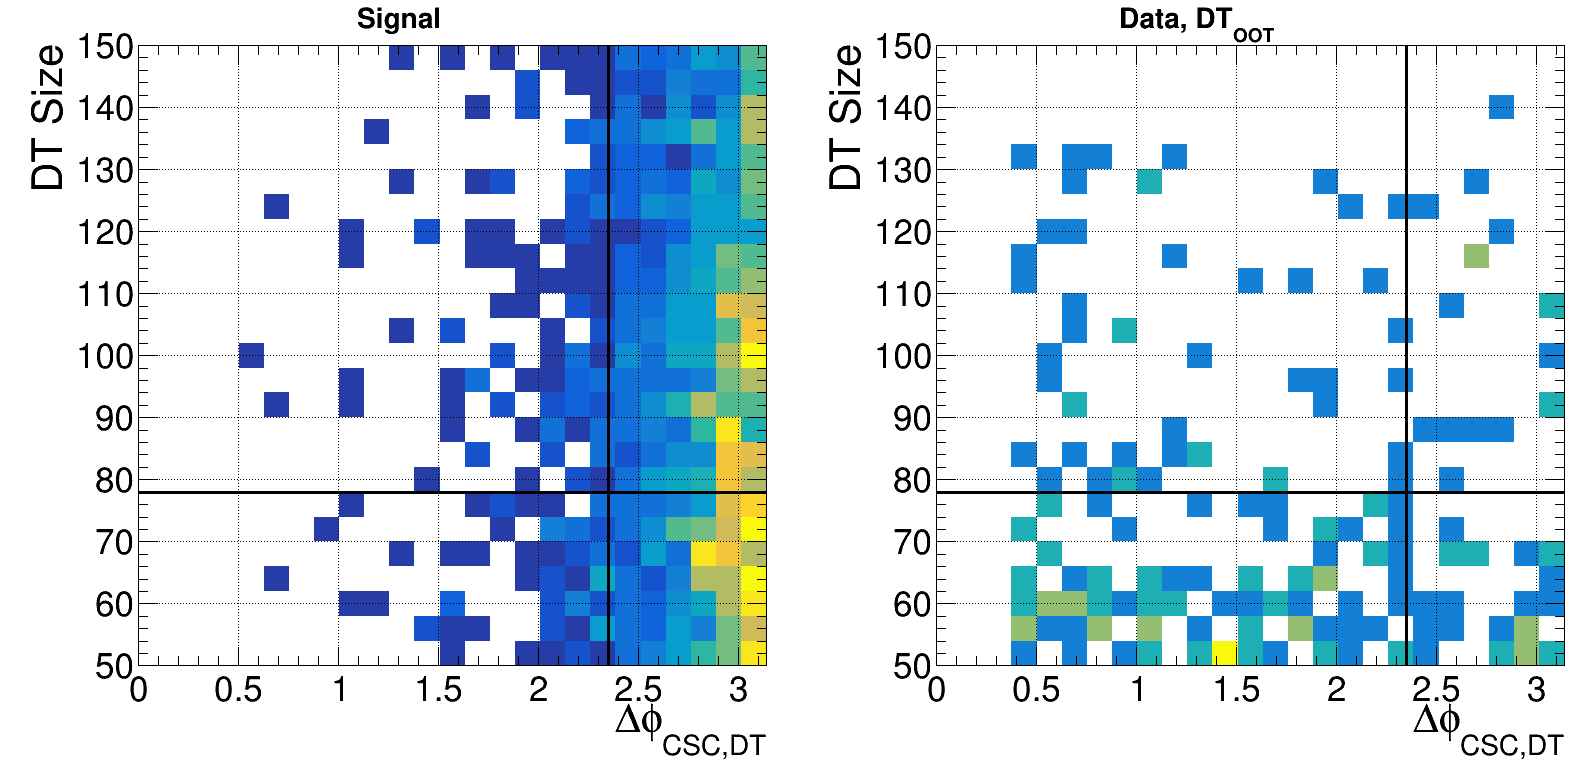

In [84]:
canvas = TCanvas('','',2*800,800)
canvas.Divide(2,1)

dopt = ('col','box')[0]
nb = 25

form = ('',f';#Delta#phi_{{CSC,{SIZE_VAR.upper()}}};{SIZE_VAR.upper()} Size;count',nb,0,np.pi,nb,50,150)

dphi_line = TLine(ABCD_DPHI,50,ABCD_DPHI,150)
size_line = TLine(0,ABCD_SIZE,np.pi,ABCD_SIZE)
dphi_line.SetLineWidth(3)
size_line.SetLineWidth(3)

if 'high' in FN_R3:
    sr_box = TBox(0, ABCD_SIZE, ABCD_DPHI, 150)
else:# 'low' in FN_R3:
    sr_box = TBox(ABCD_DPHI, ABCD_SIZE, np.pi, 150)
sr_box.SetFillColor(rt.kBlack)

latex = TLatex()
latex.SetTextAlign(23)
latex.SetTextSize(0.04)

canvas.cd(1).SetGrid()
h_mc = rdfs['mc'].Histo2D(form,'tag_dPhi','tag_size').GetValue()
h_mc.Draw(dopt)

dphi_line.Draw()
size_line.Draw()
latex.DrawLatexNDC(0.5, 1, 'Signal'+(f', {SIZE_VAR.upper()}_{{OOT}}' if 'OOT' in FN_MC else ''))

canvas.cd(2).SetGrid()
h_r3 = rdfs['r3'].Histo2D(form,'tag_dPhi','tag_size').GetValue()
h_r3.Draw(dopt)

dphi_line.Draw()
size_line.Draw()
latex.DrawLatexNDC(0.5, 1, 'Data'+(f', {SIZE_VAR.upper()}_{{OOT}}' if 'OOT' in FN_R3 else ''))
if 'OOT' not in FN_R3:
    sr_box.Draw()

canvas.Draw()

#  Size Closure

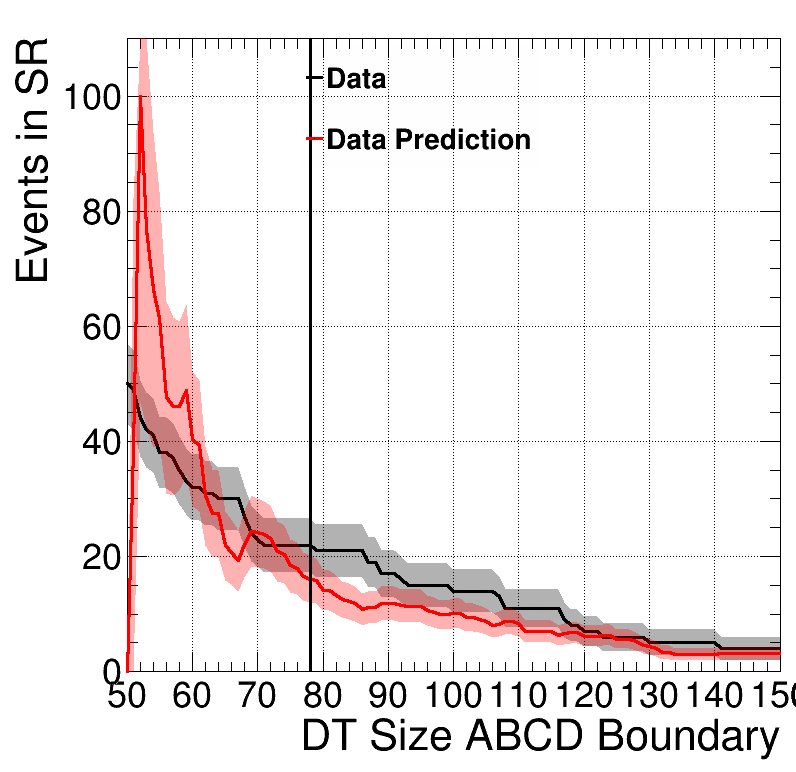

In [85]:
canvas = TCanvas('','',800,800)
canvas.SetGrid()
# canvas.SetLogy()

legend = TLegend(0.38, 0.78, 0.68, 0.94)
legend.SetBorderSize(0)
legend.SetFillColorAlpha(rt.kBlack, 0)#0.2)
legend.SetTextSize(0.04)
legend.SetMargin(0.1)

# sizes = np.linspace(50,150,100)

if 'high' in FN_MC:
    a_mc = [rdfs['mc'].Filter(f'(tag_dPhi < {ABCD_DPHI}) && (tag_size >= {sz})').Sum('weight') for sz in sizes]
    b_mc = [rdfs['mc'].Filter(f'(tag_dPhi < {ABCD_DPHI}) && (tag_size < {sz})').Sum('weight') for sz in sizes]
    c_mc = [rdfs['mc'].Filter(f'(tag_dPhi >= {ABCD_DPHI}) && (tag_size < {sz})').Sum('weight') for sz in sizes]
    d_mc = [rdfs['mc'].Filter(f'(tag_dPhi >= {ABCD_DPHI}) && (tag_size >= {sz})').Sum('weight') for sz in sizes]

    a_r3 = [rdfs['r3'].Filter(f'(tag_dPhi < {ABCD_DPHI}) && (tag_size >= {sz})').Sum('weight') for sz in sizes]
    b_r3 = [rdfs['r3'].Filter(f'(tag_dPhi < {ABCD_DPHI}) && (tag_size < {sz})').Sum('weight') for sz in sizes]
    c_r3 = [rdfs['r3'].Filter(f'(tag_dPhi >= {ABCD_DPHI}) && (tag_size < {sz})').Sum('weight') for sz in sizes]
    d_r3 = [rdfs['r3'].Filter(f'(tag_dPhi >= {ABCD_DPHI}) && (tag_size >= {sz})').Sum('weight') for sz in sizes]
else:
    a_mc = [rdfs['mc'].Filter(f'(tag_dPhi >= {ABCD_DPHI}) && (tag_size >= {sz})').Sum('weight') for sz in sizes]
    b_mc = [rdfs['mc'].Filter(f'(tag_dPhi >= {ABCD_DPHI}) && (tag_size < {sz})').Sum('weight') for sz in sizes]
    c_mc = [rdfs['mc'].Filter(f'(tag_dPhi < {ABCD_DPHI}) && (tag_size < {sz})').Sum('weight') for sz in sizes]
    d_mc = [rdfs['mc'].Filter(f'(tag_dPhi < {ABCD_DPHI}) && (tag_size >= {sz})').Sum('weight') for sz in sizes]

    a_r3 = [rdfs['r3'].Filter(f'(tag_dPhi >= {ABCD_DPHI}) && (tag_size >= {sz})').Sum('weight') for sz in sizes]
    b_r3 = [rdfs['r3'].Filter(f'(tag_dPhi >= {ABCD_DPHI}) && (tag_size < {sz})').Sum('weight') for sz in sizes]
    c_r3 = [rdfs['r3'].Filter(f'(tag_dPhi < {ABCD_DPHI}) && (tag_size < {sz})').Sum('weight') for sz in sizes]
    d_r3 = [rdfs['r3'].Filter(f'(tag_dPhi < {ABCD_DPHI}) && (tag_size >= {sz})').Sum('weight') for sz in sizes]

a_mc = np.array([x.GetValue() for x in a_mc])
b_mc = np.array([x.GetValue() for x in b_mc])
c_mc = np.array([x.GetValue() for x in c_mc])
d_mc = np.array([x.GetValue() for x in d_mc])

a_r3 = np.array([x.GetValue() for x in a_r3])
b_r3 = np.array([x.GetValue() for x in b_r3])
c_r3 = np.array([x.GetValue() for x in c_r3])
d_r3 = np.array([x.GetValue() for x in d_r3])

ap_mc = np.array([b*d/c if c else -1 for b,c,d in zip(b_mc,c_mc,d_mc)])
ap_r3 = np.array([b*d/c if c else -1 for b,c,d in zip(b_r3,c_r3,d_r3)])

ae_mc = np.sqrt(a_mc)
ae_r3 = np.sqrt(a_r3)
ape_mc = np.array([a*(1/b+1/c+1/d)**(1/2) if b and c and d else 0 for a,b,c,d in zip(ap_mc,b_mc,c_mc,d_mc)])
ape_r3 = np.array([a*(1/b+1/c+1/d)**(1/2) if b and c and d else 0 for a,b,c,d in zip(ap_r3,b_r3,c_r3,d_r3)])

# **** #
xx = sizes
xlabel, ylabel = f'{SIZE_VAR.upper()} Size ABCD Boundary', 'Events in SR'

values = [[a_r3,ae_r3],[ap_r3,ape_r3]]#,[a_mc,ae_mc],[ap_mc,ape_mc]]
names = ['Data', 'Data Prediction']#,'Signal', 'Signal Prediction',]

hmin, hmax = 0, 1.1*max([max(v[0]) for v in values])
# hmin, hmax = 1e-9, 1.1*max([max(v[0]) for v in values])
for igr, (vv, ve) in enumerate(values):
    # if 'median' in ylabel.lower():
    #     yy = np.array([[np.median(v),np.median(v)-np.percentile(v,25),np.percentile(v,75)-np.median(v)] if len(v) else [0,0,0] for v in val])
    # elif 'mean' in ylabel.lower():
    #     yy = np.array([[v.mean(),v.mean()-np.percentile(v,25),np.percentile(v,75)-v.mean()] if len(v) else [0,0,0] for v in val])
    gr = TGraphErrors(len(xx),xx*1.,vv*1.,xx*0.,ve*1.)
    gr.GetXaxis().SetLimits(np.min(xx), np.max(xx))
    gr.SetMinimum(hmin)
    gr.SetMaximum(hmax)
    gr.SetName(names[igr])
    gr.GetXaxis().SetTitle(xlabel)
    gr.GetYaxis().SetTitle(ylabel)

    gr.SetLineWidth(3)
    gr.SetLineColor(SCL[igr])
    # gr.SetLineColor(SCL[0 if 'Signal' in names[igr] else 1])
    gr.SetLineStyle(rt.kDashed if '<' in names[igr] else rt.kSolid)
    gr.SetFillColorAlpha(gr.GetLineColor(), 0.3)
    gr.Draw(('' if igr else 'A')+' L3')
    legend.AddEntry(gr,gr.GetName(),'LP')
    gc.append(gr)

size_line = TLine(ABCD_SIZE,0,ABCD_SIZE,hmax)
size_line.Draw()
size_line.SetLineWidth(3)

legend.Draw()
canvas.Draw()


In [86]:
# table
idx0 = np.argwhere(sizes == ABCD_SIZE)[0][0]
print(r'\begin{center}')
print(r'\begin{tabular}{c|cccc|c}')
print(r'    \hline')
print(f'    \\textbf{{{SIZE_VAR.upper()} Size}} & D & C & B & A & $A_{{pred}}=\\frac{{B \\cdot D}}{{C}}$ \\\\')
print(r'    \hline\hline')
for i in range(idx0-3, idx0+4):
    print(f'    {sizes[i]:.0f} & {d_r3[i]:.0f} & {c_r3[i]:.0f} & {b_r3[i]:.0f} & {a_r3[i]:.0f} ($\pm$ {a_r3[i]**0.5:.2f}) & {ap_r3[i]:.2f} ($\pm$ {ape_r3[i]:.2f}) \\\\')
    if i-idx0 in (-1, 0):
        print(r'    \hline')
print(r'\end{tabular}')
print(r'\end{center}')

\begin{center}
\begin{tabular}{c|cccc|c}
    \hline
    \textbf{DT Size} & D & C & B & A & $A_{pred}=\frac{B \cdot D}{C}$ \\
    \hline\hline
    75 & 63 & 96 & 28 & 22 ($\pm$ 4.69) & 18.38 ($\pm$ 4.58) \\
    76 & 62 & 97 & 28 & 22 ($\pm$ 4.69) & 17.90 ($\pm$ 4.46) \\
    77 & 59 & 100 & 28 & 22 ($\pm$ 4.69) & 16.52 ($\pm$ 4.14) \\
    \hline
    78 & 58 & 101 & 28 & 22 ($\pm$ 4.69) & 16.08 ($\pm$ 4.03) \\
    \hline
    79 & 56 & 103 & 29 & 21 ($\pm$ 4.58) & 15.77 ($\pm$ 3.93) \\
    80 & 52 & 107 & 29 & 21 ($\pm$ 4.58) & 14.09 ($\pm$ 3.54) \\
    81 & 52 & 107 & 29 & 21 ($\pm$ 4.58) & 14.09 ($\pm$ 3.54) \\
\end{tabular}
\end{center}


# deltaPhi Closure

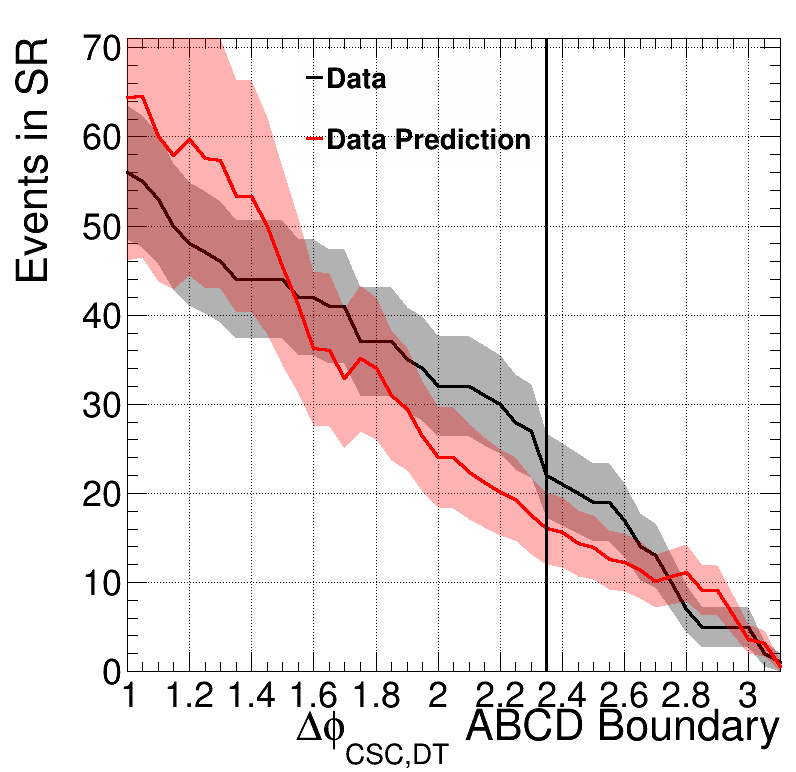

In [87]:
canvas = TCanvas('','',800,800)
canvas.SetGrid()
# canvas.SetLogy()

legend = TLegend(0.38, 0.78, 0.68, 0.94)
legend.SetBorderSize(0)
legend.SetFillColorAlpha(rt.kBlack, 0)#0.2)
legend.SetTextSize(0.04)
legend.SetMargin(0.1)

# dphis = np.linspace(0.4,np.pi,100)

if 'high' in FN_MC:
    a_mc = [rdfs['mc'].Filter(f'(tag_dPhi < {dp}) && (tag_size >= {ABCD_SIZE})').Sum('weight') for dp in dphis]
    b_mc = [rdfs['mc'].Filter(f'(tag_dPhi < {dp}) && (tag_size < {ABCD_SIZE})').Sum('weight') for dp in dphis]
    c_mc = [rdfs['mc'].Filter(f'(tag_dPhi >= {dp}) && (tag_size < {ABCD_SIZE})').Sum('weight') for dp in dphis]
    d_mc = [rdfs['mc'].Filter(f'(tag_dPhi >= {dp}) && (tag_size >= {ABCD_SIZE})').Sum('weight') for dp in dphis]

    a_r3 = [rdfs['r3'].Filter(f'(tag_dPhi < {dp}) && (tag_size >= {ABCD_SIZE})').Sum('weight') for dp in dphis]
    b_r3 = [rdfs['r3'].Filter(f'(tag_dPhi < {dp}) && (tag_size < {ABCD_SIZE})').Sum('weight') for dp in dphis]
    c_r3 = [rdfs['r3'].Filter(f'(tag_dPhi >= {dp}) && (tag_size < {ABCD_SIZE})').Sum('weight') for dp in dphis]
    d_r3 = [rdfs['r3'].Filter(f'(tag_dPhi >= {dp}) && (tag_size >= {ABCD_SIZE})').Sum('weight') for dp in dphis]
else:
    a_mc = [rdfs['mc'].Filter(f'(tag_dPhi >= {dp}) && (tag_size >= {ABCD_SIZE})').Sum('weight') for dp in dphis]
    b_mc = [rdfs['mc'].Filter(f'(tag_dPhi >= {dp}) && (tag_size < {ABCD_SIZE})').Sum('weight') for dp in dphis]
    c_mc = [rdfs['mc'].Filter(f'(tag_dPhi < {dp}) && (tag_size < {ABCD_SIZE})').Sum('weight') for dp in dphis]
    d_mc = [rdfs['mc'].Filter(f'(tag_dPhi < {dp}) && (tag_size >= {ABCD_SIZE})').Sum('weight') for dp in dphis]

    a_r3 = [rdfs['r3'].Filter(f'(tag_dPhi >= {dp}) && (tag_size >= {ABCD_SIZE})').Sum('weight') for dp in dphis]
    b_r3 = [rdfs['r3'].Filter(f'(tag_dPhi >= {dp}) && (tag_size < {ABCD_SIZE})').Sum('weight') for dp in dphis]
    c_r3 = [rdfs['r3'].Filter(f'(tag_dPhi < {dp}) && (tag_size < {ABCD_SIZE})').Sum('weight') for dp in dphis]
    d_r3 = [rdfs['r3'].Filter(f'(tag_dPhi < {dp}) && (tag_size >= {ABCD_SIZE})').Sum('weight') for dp in dphis]

a_mc = np.array([x.GetValue() for x in a_mc])
b_mc = np.array([x.GetValue() for x in b_mc])
c_mc = np.array([x.GetValue() for x in c_mc])
d_mc = np.array([x.GetValue() for x in d_mc])

a_r3 = np.array([x.GetValue() for x in a_r3])
b_r3 = np.array([x.GetValue() for x in b_r3])
c_r3 = np.array([x.GetValue() for x in c_r3])
d_r3 = np.array([x.GetValue() for x in d_r3])

ap_mc = np.array([b*d/c if c else -1 for b,c,d in zip(b_mc,c_mc,d_mc)])
ap_r3 = np.array([b*d/c if c else -1 for b,c,d in zip(b_r3,c_r3,d_r3)])

ae_mc = np.sqrt(a_mc)
ae_r3 = np.sqrt(a_r3)
ape_mc = np.array([a*(1/b+1/c+1/d)**(1/2) if b and c and d else 0 for a,b,c,d in zip(ap_mc,b_mc,c_mc,d_mc)])
ape_r3 = np.array([a*(1/b+1/c+1/d)**(1/2) if b and c and d else 0 for a,b,c,d in zip(ap_r3,b_r3,c_r3,d_r3)])

# **** #
xx = dphis
xlabel, ylabel = f'#Delta#phi_{{CSC,{SIZE_VAR.upper()}}} ABCD Boundary', 'Events in SR'

values = [[a_r3,ae_r3],[ap_r3,ape_r3]]#,[a_mc,ae_mc],[ap_mc,ape_mc]]
names = ['Data', 'Data Prediction']#,'Signal', 'Signal Prediction',]

hmin, hmax = 0, 1.1*max([max(v[0]) for v in values])
for igr, (vv, ve) in enumerate(values):
    # if 'median' in ylabel.lower():
    #     yy = np.array([[np.median(v),np.median(v)-np.percentile(v,25),np.percentile(v,75)-np.median(v)] if len(v) else [0,0,0] for v in val])
    # elif 'mean' in ylabel.lower():
    #     yy = np.array([[v.mean(),v.mean()-np.percentile(v,25),np.percentile(v,75)-v.mean()] if len(v) else [0,0,0] for v in val])
    gr = TGraphErrors(len(xx),xx*1.,vv*1.,xx*0.,ve*1.)
    gr.GetXaxis().SetLimits(np.min(xx), np.max(xx))
    gr.SetMinimum(hmin)
    gr.SetMaximum(hmax)
    gr.SetName(names[igr])
    gr.GetXaxis().SetTitle(xlabel)
    gr.GetYaxis().SetTitle(ylabel)

    gr.SetLineWidth(3)
    gr.SetLineColor(SCL[igr])
    # gr.SetLineColor(SCL[0 if 'Signal' in names[igr] else 1])
    gr.SetLineStyle(rt.kDashed if '<' in names[igr] else rt.kSolid)
    gr.SetFillColorAlpha(gr.GetLineColor(), 0.3)
    gr.Draw(('' if igr else 'A')+' L3')
    legend.AddEntry(gr,gr.GetName(),'LP')
    gc.append(gr)

dphi_line = TLine(ABCD_DPHI,0,ABCD_DPHI,hmax)
dphi_line.Draw()
dphi_line.SetLineWidth(3)

legend.Draw()
canvas.Draw()


In [88]:
# table
idx0 = np.argwhere(dphis == ABCD_DPHI)[0][0]
print(r'\begin{center}')
print(r'\begin{tabular}{c|cccc|c}')
print(r'    \hline')
print(f'    $\\mathbf{{|\\Delta\\phi_{{CSC,{SIZE_VAR.upper()}}}}}$ & D & C & B & A & $A_{{pred}}=\\frac{{B \\cdot D}}{{C}}$ \\\\')
print(r'    \hline\hline')
for i in range(idx0-3, idx0+4):
    print(f'    {dphis[i]:.2f} & {d_r3[i]:.0f} & {c_r3[i]:.0f} & {b_r3[i]:.0f} & {a_r3[i]:.0f} ($\pm$ {a_r3[i]**0.5:.2f}) & {ap_r3[i]:.2f} ($\pm$ {ape_r3[i]:.2f}) \\\\')
    if i-idx0 in (-1, 0):
        print(r'    \hline')
print(r'\end{tabular}')
print(r'\end{center}')

\begin{center}
\begin{tabular}{c|cccc|c}
    \hline
    $\mathbf{|\Delta\phi_{CSC,DT}}$ & D & C & B & A & $A_{pred}=\frac{B \cdot D}{C}$ \\
    \hline\hline
    2.20 & 50 & 92 & 37 & 30 ($\pm$ 5.48) & 20.11 ($\pm$ 4.84) \\
    2.25 & 52 & 94 & 35 & 28 ($\pm$ 5.29) & 19.36 ($\pm$ 4.68) \\
    2.30 & 53 & 97 & 32 & 27 ($\pm$ 5.20) & 17.48 ($\pm$ 4.30) \\
    \hline
    2.35 & 58 & 101 & 28 & 22 ($\pm$ 4.69) & 16.08 ($\pm$ 4.03) \\
    \hline
    2.40 & 59 & 102 & 27 & 21 ($\pm$ 4.58) & 15.62 ($\pm$ 3.94) \\
    2.45 & 60 & 104 & 25 & 20 ($\pm$ 4.47) & 14.42 ($\pm$ 3.71) \\
    2.50 & 61 & 105 & 24 & 19 ($\pm$ 4.36) & 13.94 ($\pm$ 3.62) \\
\end{tabular}
\end{center}
